# Machine Learning from Scratch

### In this project, I worked with linear model fitting, PCA, K-Means Clustering, SIngle and Multi-Class Classification, Logistic Regression using GD and SVM and MNIST Classification using Neural Networks.

[1](#question1): Linear Fitting (10 points)

[2](#question2): Clustering (14 points)

[3](#question3): Linear Classification (26 points)

[4](#question4): Non-linear Classification (25 points)

[5](#question5): Neural Networks (25 points)

## Datasets

We will be using two datasets for the whole project: _IRIS_ and _MNIST_. Both datasets will be downloaded directly in the notebook using the `skdataset` library. Keep in mind that you will need to be connected to Internet to be able to download the datasets. If you want to work offline, you are free to save your dataset to npy file locally and load them while offline although this is not officially supported.

**_IRIS_**: The _IRIS_ dataset contains the following features in order: _sepal length_, _sepal width_, _petal length_, _petal width_. Classes names are: __Iris Setosa__ for label **0**, __Iris Versicolour__ for label **1**, and __Iris Virginica__ for label **2**.

**_MNIST_**: _MNIST_ is a dataset composed of images of handwritten digits. The features of each image are the pixels themselves.

The script will generate two subsets for each of the two datasets, a training subset (**X\_dataset** and **Y\_dataset** with **dataset** the name of the dataset) and a test subset (**X\_dataset\_test** and **Y\_dataset\_test**).

We will test correctness of your code on _Hidden_ set.

**Warning:** as _Hidden_ may have different dimensions from _IRIS_ and _MNIST_, hard-coded solutions may not work, thus resulting in lower grades. You need to make sure that your code would work if applied on a different number of samples and a different number of features/pixels.

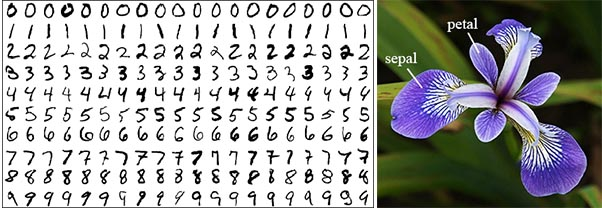

## Packages

In [1]:
# Importing packages
import numpy as np
import matplotlib.pyplot as plt

from scipy import optimize
from sklearn import datasets as skdataset
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
# Setting the seed
RAND_ST = 42

## Data Loading

The following cells are used to load both datasets, _Iris_ and _MNIST_.

In [3]:
def load_iris_dataset(num_classes=2):
    # Load the datadet from SkDataset
    iris = skdataset.load_iris()
    X = iris.data
    Y = iris.target
    # Reduce the number of classes
    idx = Y < num_classes
    X = X[idx]
    Y = Y[idx]
    return X, Y

In [4]:
def load_mnist_dataset(num_classes=2):
    # Load the datadet from SkDataset
    X, Y = skdataset.fetch_openml('mnist_784', version=1, return_X_y=True,as_frame=False)
    Y = Y.astype(np.int64)
    # Reduce the number of classes
    idx = Y < num_classes
    X = X[idx]
    Y = Y[idx]
    return X, Y

def load_mnist_dataset_onevsall(class_id=7):
    # Load the datadet from SkDataset
    X, Y = skdataset.fetch_openml('mnist_784', version=1, return_X_y=True,as_frame=False)
    Y = Y.astype(np.int64)
    # One versus all
    idx = Y == class_id
    Y[~idx] = 0
    Y[idx]  = 1
    return X, Y

## Functions for visualization

In [5]:
def plot_dataset(X, Y, dims=[0,1]):
    # Keep only two dimensions
    X_reduced = X[:, dims]
    # Plot the data points
    plt.figure(figsize=(8, 6))
    plt.clf()
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=Y, cmap=plt.cm.Set1, edgecolor='k')
    plt.xlabel('Feat 1')
    plt.ylabel('Feat 2')
    plt.show()

In [6]:
def plot_correlation(X1, X2):
    # Plot both variables
    plt.figure(figsize=(8, 6))
    plt.clf()
    plt.scatter(X1, X2, edgecolor='k')
    line = np.linspace(min(X1.min(), X2.min()), max(X1.max(), X2.max()), 20)
    plt.plot(line, line, 'r')
    plt.xlabel('Variable 1')
    plt.ylabel('Variable 2')
    plt.show()

In [7]:
def plot_eigenvecs(stacked_images, n_rows, n_columns):
    n_images, n_dims = stacked_images.shape
    plt.figure()
    for i in range(n_rows*n_columns):
        plt.subplot(n_rows, n_columns, i+1)
        plt.imshow(np.reshape(stacked_images[i], [int(np.sqrt(n_dims)), int(np.sqrt(n_dims))]))
        plt.axis('off')
    plt.show()

def plot_grey_image(stacked_images, n_rows, n_columns, titles):
    n_images, n_dims = stacked_images.shape
    plt.figure()
    for i in range(n_rows*n_columns):
        plt.subplot(n_rows, n_columns, i+1)
        plt.imshow(np.reshape(stacked_images[i], [int(np.sqrt(n_dims)), int(np.sqrt(n_dims))]), cmap='gray', vmin=0, vmax=1)
        plt.axis('off')
        if len(titles) == n_rows*n_columns:
          plt.title(titles[i])
    plt.show()

In [8]:
def plot_loss_curve(logs):
    fig = plt.figure(figsize=(8, 6))
    plt.plot(logs)
    plt.show()

In [9]:
def true_positive(Y_test, y_pred):
    mask = (Y_test == 1)
    tp = (Y_test[mask] == y_pred[mask]).sum()
    return tp.item()

def true_negative(Y_test, y_pred):
    mask = (Y_test == 0) | (Y_test == -1)
    tn = (Y_test[mask] == y_pred[mask]).sum()
    return tn.item()

def false_negative(Y_test, y_pred):
    mask = (y_pred == 0) | (y_pred == -1)
    tn = (Y_test[mask] != y_pred[mask]).sum()
    return tn.item()

def false_positive(Y_test, y_pred):
    mask = (y_pred == 1)
    tn = (Y_test[mask] != y_pred[mask]).sum()
    return tn.item()

def plot_confusion_matrix(Y_test, y_pred):
    tp = true_positive(Y_test, y_pred)
    tn = true_negative(Y_test, y_pred)
    fp = false_positive(Y_test, y_pred)
    fn = false_negative(Y_test, y_pred)
    cf = np.array([[tp, fp], [fn, tn]])
    fig, ax = plt.subplots()
    ax.matshow(cf, cmap=plt.cm.Blues)
    for i in range(2):
        for j in range(2):
            c = cf[i,j]
            ax.text(i, j, str(c), va='center', ha='center')
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.show()

## Data Loading

In the following cells, the dataset is created with proper splits between training and test set.

_IRIS_ dataset

In [10]:
X, Y = load_iris_dataset(num_classes=3)
X_iris, X_iris_test, Y_iris, Y_iris_test = train_test_split(X, Y, test_size=0.1, random_state=RAND_ST) # 90% training and 10% test

_MNIST_ dataset

In [11]:
X, Y = load_mnist_dataset(num_classes=10)
X = X / 255.0
X_mnist, X_mnist_test, Y_mnist, Y_mnist_test = train_test_split(X, Y, test_size=0.1, random_state=RAND_ST) # 90% training and 10% test

## 1. Linear Fitting (10 points)
<a name='question1'></a>

[a)](#question1a) Implement the normal equation solver function **nsolve**, which takes as input the matrix **X** and the target vector **y** and returns the optimized weights **w**. Test your code with your own mockup data. (**5 points**)

[b)](#question1b) Implement **line_fit(X,y)** which should fit a linear function to the input data. Test your implementation on the following task: predict with linear fitting the _petal length (cm)_ of the Iris dataset using the three remaining variables as inputs (_sepal length (cm)_, _sepal width (cm)_ and _petal width (cm)_). Report the L2 loss on the validation set and plot a graph showing the correlation between y and your prediction on the test set. (**2 points**)

[c)](#question1c) Implement **poly_fit(X,y)** which should fit a 2nd degree polynomial to the input data. Test your implementation on the following task: predict with the polynomial the petal width (cm) of the _IRIS_ dataset using the three remaining variables as inputs (sepal length (cm), sepal width (cm), petal length (cm)). The 2nd degree polynomial should consider all possible pairwise terms, i.e. $w_1x^2 + w_2xy+ w_3y^2 + w_4x+ w_5y+ w_6$ in the case of two input variables $x$ and $y$. Report the L2 loss on the validation set and plot a graph showing the correlation between $y$ and your prediction on the test set. (**3 points**)

**1.a**
<a name='question1a'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

Testing your code on mockup data.

In [12]:
def nsolve(X,y):
    """
    Write your implementation of nsolve here.

    Arguments:
    X : Data matrix
    y : Labels

    Returns:
    w : Weights 
    """

    #solution
    #print(np.shape(X))
    w = np.zeros(np.shape(X[0]))
    #print(np.shape(w))
    
    #w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y) 
    # calculating weights using the normal equation
    # XtX = np.dot(np.transpose(X),X)
    # XtXinv = np.linalg.inv(XtX)
    # XtXinvXt = np.dot(XtXinv, np.transpose(X))
    # w = np.dot(XtXinvXt,y)
    w = np.matmul(np.linalg.inv(np.matmul(X.transpose(),X)), X.transpose()).dot(y)
    #print(w)




    #end_solution


    return w

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [13]:
"""
After implementing nsolve, test it below on some mock data using np.random
"""

#solution
# noise_margin= 2
# w = np.random.rand(2,1)
# x = np.linspace(-5,5,20) # defining features
# y = w[0] + w[1]*x + noise_margin*np.random.rand(len(x)) # defining labels
# X = np.column_stack([np.ones([len(x), 1]), x.reshape(-1,1)])
x = np.random.rand(2,1)
X = np.column_stack([np.ones([len(x), 1]), x.reshape(-1,1)])
y = np.random.rand(2,1)
w = nsolve(X, y)
y_pred = X.dot(w)
# print(y)
# print(y_pred)

#end_solution


**1.b**
<a name='question1b'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [14]:
def line_fit(X,y):
    """
    Write your implementation of line_fit here.

    Arguments:
    X : Data matrix
    y : Labels

    Returns:
    w : Weights
    l2_error : L2 Prediction error using learned w
    """

    #solution
    X_train = np.column_stack([np.ones([len(X), 1]), X])

    w = nsolve(X_train, y)
    y_train_pred = X_train.dot(w)

    l2_error = np.mean(np.square(y-y_train_pred))
    print("L2 error: ",l2_error)
    print("w: ",w)


    #end_solution


    return w, l2_error

Testing your code on _IRIS_

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [15]:
"""
After implementing line_fit, test it below on IRIS Train set.
Print the L2 error on the Training set.
"""

#solution
#x = np.random.rand(2,1)
#y = np.random.rand(2,1)
#x_iris = X_iris[0:2]+X_iris[3]
y_train = [row[2] for row in X_iris]
x_train = np.delete(X_iris,2,1)

print(np.shape(x_train))
print(np.shape(y_train))

# x1 = [row[:2] for row in X_iris]
# x2 = [row[3] for row in X_iris]
# x = x1,x2
# print(np.shape(x))
# print(np.shape(X_iris))

w, l2_error = line_fit(x_train,y_train)

#end_solution


(135, 3)
(135,)
L2 error:  0.09254280323050398
w:  [-0.35183945  0.7487918  -0.64362946  1.43598914]


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [16]:
"""
After implementing line_fit, test it below on IRIS Test set.
Print the L2 error with respect to Test set.
"""

#solution
y_test = [row[2] for row in X_iris]
x_test = np.delete(X_iris,2,1)
x_test = np.column_stack([np.ones([len(x_test), 1]), x_test])
y_test_pred = x_test.dot(w)


l2_error = np.mean(np.square(y_test-y_test_pred))
print("L2 error: ",l2_error)

#end_solution


L2 error:  0.09254280323050398


In [17]:
"""
After implementing line_fit, test it below on IRIS Test set.
Print the L2 error with respect to Test set.
"""

#solution
y_test = [row[2] for row in X_iris_test]
x_test = np.delete(X_iris_test,2,1)
x_test = np.column_stack([np.ones([len(x_test), 1]), x_test])
y_test_pred = x_test.dot(w)

l2_error = np.mean(np.square(y_test-y_test_pred))
print("L2 error: ",l2_error)

#end_solution


L2 error:  0.16248765157331652


Showing the correlation between X and y.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

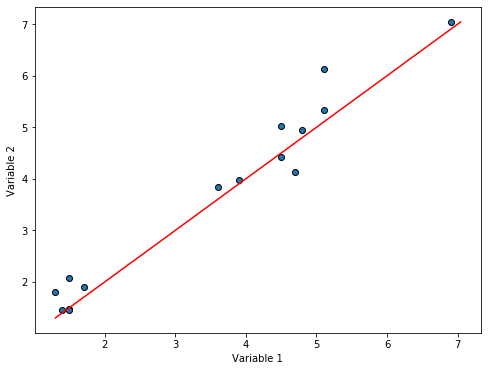

In [18]:
"""
Below, plot and display the correlation between true y and predicted values.
"""
#solution
plot_correlation(np.array(y_test), np.array(y_test_pred))
#end_solution


**1.c**
<a name='question1c'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [19]:
def poly_fit(X,y):
    """
    Write your implementation of poly_fit here.

    Arguments:
    X : Data matrix
    y : Labels

    Returns:
    w : Weights
    l2_error : L2 prediction error using learned w
    """

    #solution
    
    ### ASK IN LAB WHAT IS w1x2+w2xy+w3y2+w4x+w5y+w6 and difference between line fit and polyfit
    # Change the formulas below
    Xsq = np.square(X)
    X_polynomial = np.column_stack([np.ones([len(X), 1]), X, Xsq])

    w = nsolve(X_polynomial, y)
    print(w)

    l2_error = 0;
    y_pred = X_polynomial.dot(w)
    l2_error = np.mean(np.square(y-y_pred))
    
    print("L2 error: ",l2_error)

    #end_solution


    return w, l2_error

Testing your code on _IRIS_.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [20]:
"""
After implementing poly_fit, test it below on IRIS Training set.
Print L2 error with respect to training set.
"""

#solution
#X = X_iris
#Y = Y_iris


y_train = [row[2] for row in X_iris]
x_train = np.delete(X_iris,2,1)

w, l2_error = poly_fit(x_train,y_train)

#w, l2_error = poly_fit(X, Y)
print(l2_error)
print(w)
#y_pred = X.dot(w)


#end_solution


[ 1.93226492 -0.63753042  0.11634721  2.65078182  0.10286123 -0.0724573
 -0.42742853]
L2 error:  0.0736381342923637
0.0736381342923637
[ 1.93226492 -0.63753042  0.11634721  2.65078182  0.10286123 -0.0724573
 -0.42742853]


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [21]:
"""
After implementing poly_fit, test it below on IRIS Test set.
Print L2 error with respect to test set.
"""

#solution
y_test = [row[2] for row in X_iris_test]
x_test = np.delete(X_iris_test,2,1)
x_test = np.column_stack([np.ones([len(x_test), 1]), x_test, np.square(x_test)])
y_test_pred = x_test.dot(w)

l2_error = np.mean(np.square(y_test-y_test_pred)) #Change to correct function for all functions.
print("L2 error: ",l2_error)

#end_solution


L2 error:  0.12699597167456197


Showing the correlation between X and y.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

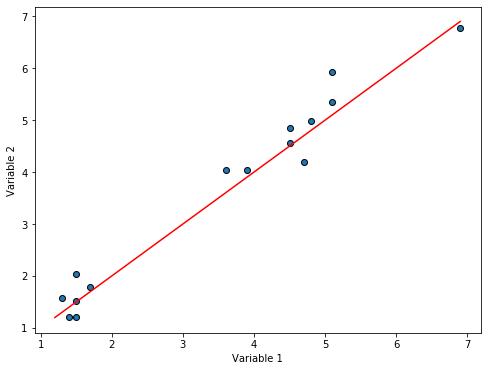

In [22]:
"""
Below, plot and display the correlation between true y and predicted values
"""

#solution

plot_correlation(np.array(y_test), np.array(y_test_pred))
#end_solution


## 2. Clustering (14 points)
<a name='question2'></a>

[a)](#question2a) Implement a function pca(X, ndims) that performs PCA over the input data X and returns both the mean vector  ̄X and the ndims top components. The top components are the eigen vectors linked to the top eigen values computed from the covariance matrix. Try your function on the _MNIST_ dataset, which is composed of 10 digit classes. Display the top 10 components fitted on the train dataset as images. Next, check that you can reconstruct perfectly an input digit from the test set using all components, by implementing pca_projection(X, mean_vec, eig_vecs) and pca_reconstruction(weights, mean_vec, eig_vecs). (**7 points**)

[b)](#question2b) Perform independent research on the clustering algorithm k-means. Implement a function kmeans performing k-means on input data X. Propose the interface to that function (i.e., what is its input and output?) and write in three sentences why this is. Apply you kmeans implementation on the _MNIST_ training set with k= 10 clusters and display the centroids as images. (**4 points** + **1 points** on hidden dataset)

[c)](#question2c) Describe the k-means algorithm, highlighting similarities and differences from PCA. Compare the reconstruction loss on the validation set for both k-means and PCA. Write no more than ten sentences. (**2 points**)

**2.a**
<a name='question2a'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [23]:
def pca(X, ndims):
    """
    Write your implementation of PCA here.

    Arguments:
    X : Data matrix
    ndims : Number of reduced dimensions

    Returns:
    mean_vec : Data mean
    top_eig_vecs : Selected eigen vectors, a matrix where each column corresponds
                    to an eigen vector
    """

    #solution
    mean_vec = np.mean(X, axis=0)
    #print(np.mean(X))
    #print(mean_vec.shape)
    #print(mean_vec)
    dx = X - mean_vec
    #print(np.max(dx))
    cov = np.transpose(dx).dot(dx)
    #print(cov)
    #print(X[600:700])
    #print(cov)
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    i = eigenvalues.argsort()[::-1]   
    eigenvalues = eigenvalues[i]
    eigenvectors = eigenvectors[:,i]
    #print(eigenvectors)
    #print(np.max(eigenvectors[0]))
    
    top_eig_vecs = eigenvectors[:,:ndims]

    #end_solution


    return mean_vec, top_eig_vecs

Testing your code on _MNIST_

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

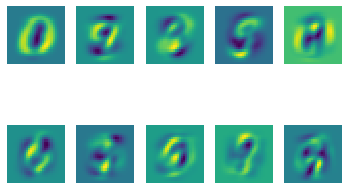

In [24]:
"""
Below, test your PCA on  MNIST dataset.
Plot and display the selected eigen vectors returned by PCA.
"""

#solution
X = X_mnist
Y = Y_mnist
mean_vec, top_eig_vecs = pca(X, 10)

# plt.style.context('seaborn-whitegrid')
# plt.ylabel('Variance')
# plt.xlabel('Features')
# plt.title('Top Eigen Vectors')



# plt.plot(top_eig_vecs)
#print(top_eig_vecs)
n,d = (top_eig_vecs.T).shape
#print(top_eig_vecs.shape)
plot_eigenvecs(top_eig_vecs.T, 2, 5)

#print(top_eig_vecs)
#print(X.shape)






#end_solution


Now, we can evaluate if the code is working properly by projecting the first image of the test set on the eigen vectors.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>


In [25]:
def pca_projection(X, mean_vec, eig_vecs):
    """
    Write your implenetation of PCA projection here.

    Arguments:
    X : Data matrix
    mean_vec : Data mean
    eig_vecs : A numpy array where each column corresponds to an eigen vector

    Returns:
    weights : Weights corresponding to the eigen vectors
    """

    #solution

    #Projection
    dx = X-mean_vec
    weights = (eig_vecs.T.dot(dx.T)).T
    #print(weights.shape)

    

    #end_solution


    return weights

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [26]:
def pca_reconstruction(weights, mean_vec, eig_vecs):
    """
    Write your implementation of PCA reconstruction here.

    Arguments:
    weights : Weights obtained from pca_projection
    mean_vec : Data mean
    eig_vecs : A numpy array where each column corresponds to an eigen vector
    """

    #solution

    reconstruction = weights.dot(eig_vecs.T) + mean_vec
    #end_solution


    return reconstruction

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

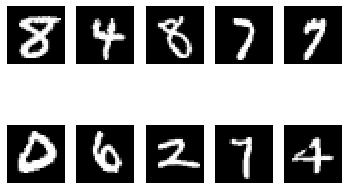

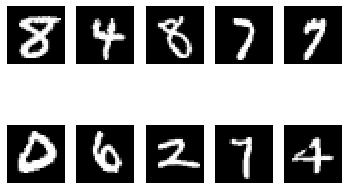

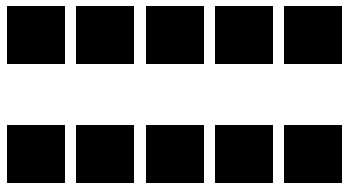

In [27]:
"""
Below, 
1. Perform  PCA on MNIST training set, without reducing dimensions.
2. Project the first image of Test set to the eigen vectors using pca_projection.
3. Reconstruct that image using pca_reconstruction.
4. Display side-by-side, the Test image, its projection and the 
   pixelwise difference between the two. Use the plotting functions provided.
"""

#solution
X = X_mnist
X_test = X_mnist_test
Y = Y_mnist
Y_test = Y_mnist_test
n, d = X.shape
mean_vec, top_eig_vecs = pca(X, d)
weights = pca_projection(X_test, mean_vec, top_eig_vecs)
reconstruction = pca_reconstruction(weights, mean_vec, top_eig_vecs)
#plt.imshow(reconstruction)
#plt.imshow(X_test)

plot_grey_image(reconstruction, 2, 5, [])
plot_grey_image(X_test, 2, 5, [])
plot_grey_image((reconstruction-X_test), 2, 5, [])
#print(reconstruction-X_test)


#end_solution


**2.b**
<a name='question2b'></a>

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [28]:
def kmeans(X, k, max_iterations=1000):
    """
    Write your implementation of kmeans here.

    Arguments:
    X : Data matrix.
    k : Your choise of k, an integer.
    max_iterations : The number of iterations after which to stop.

    Returns:
    centroids: The learned cluster centroids.
    """

    #solution
    n,d = np.shape(X) 
    min = X.min(axis=0)
    max = X.max(axis=0)
    centroids = np.random.rand(k, d)*(max-min)+min #Initialising k centroids of same dim as X all having a different value scaled within the range of training values
    centroids_old = np.zeros((k, d)) #Initialising array to save centroids from previous loop


    iteration = 0
    #Running the loop until there are no changes in the centroid or until the max iterations
    while np.sum(np.sum(centroids_old-centroids))!= 0 and iteration<max_iterations:

        centroids_old = centroids.copy()

        distances = []
        #distances will be n*k where it will have distances of centroid for all k with x stored in a matrix
        for i in range(k):
            distances.append(np.ones((1,n))*np.sum(np.square(X - centroids[i,:]),axis=1)) #Finding the distance between all the clusters and the dataset
        distances = np.array(distances)
        
        
        # distances = np.ones((1,n))*np.sum(np.square(X-centroids[0,:]),axis=1)
        # #distances = np.ones((1,n))
        # for i in range(k-1):
        #     distances = np.append(distances,np.ones((1,n))*np.sum((X - centroids[i+1,:])**2,axis=1),axis=0)
        
        cluster = distances.argmin(axis=0) #Saving the index of x where the distances of x with the old centroids for each centroid was minimum
        cluster = np.transpose(cluster*np.ones((1,n)))
        
        
        # Update the cluster centres	
        for i in range(k):
            thisCluster = np.where(cluster==i,1,0) 
            if sum(thisCluster)>0: #if any of the clusters for the current centroid have the minimum distance, then update else skip the update
                centroids[i,:] = np.sum(X*thisCluster,axis=0)/np.sum(thisCluster) #finding the new centroid with X data which were closest to the current centroid
    
        iteration += 1

    #end_solution


    return centroids

Testing your code on _MNIST_

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

68.62600363823357


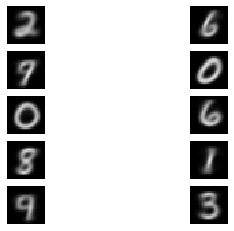

In [29]:
"""
Below, test your kmeans on the MNIST dataset.
For all 10 digits, plot and display the cluster centroids as an image grid. 
Use provided plotting functions.
"""

#solution

#X_mnist, X_mnist_test, Y_mnist, Y_mnist_test

centroids=kmeans(X_mnist, 10, 10)

num_test = np.shape(X_mnist_test)[0]
# Compute distances
distances = np.ones((1,num_test))*np.sum((X_mnist_test-centroids[0,:])**2,axis=1)
for j in range(10-1):
    distances = np.append(distances,np.ones((1,num_test))*np.sum((X_mnist_test-centroids[j+1,:])**2,axis=1),axis=0)

average_error = np.average(distances)
print(average_error)

plot_grey_image(centroids,5,2,"Cluster Centroids KMeans")


#end_solution


**2.c**
<a name='question2c'></a>

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply_:

## 3. Linear Classification (26 points)
<a name='question3'></a>

[a)](#question3a) Implement the normal equation-based binary linear classifier lclass(examplesA, examplesB, testExamples) where the first two arguments are the set of samples from class A and class B respectively and the third is the test. The function should return a vector of 0s and 1s, 0 if test is in A and 1 otherwise. It should, for simplicity, both train and test in one function call. (**5 points**)

[b)](#question3b) Test this on all the samples in _IRIS_, Setosa vs non-Setosa, etc and propose a simple analysis (text, figure, table) of the result you find, but not longer than ten sentences. (**5 points** + **1 points** on hidden
dataset)

[c)](#question3c) Perform independent research how to do multi-class classification. Implement lclass_prob(examplesA, examplesB, testExamples) and lmclass(examples, class, testExamples) that together perform multi-class classification of the examples examples according to the vector of labels class of the same size and test it with testExamples by returning a matrix, where each row expresses the probability of a sample in testExamples to belong to each class. Give the accuracy of your model. (**9 points** + **1 points** on hidden dataset)

[d)](#question3d) Present findings applying multi-class classification on _IRIS_ dataset with 3 classes. You can include figures and tables if needed. Write no longer than ten sentences. (**5 points**)

**3.a**
<a name='question3a'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [30]:
def lclass(examplesA, examplesB, testExample):
    """
    Write your implementation of normal equation based linear classifier here.

    Arguments:
    examplesA : Matrix of samples from class A
    examplesB : Matrix of samples from class B
    testExample : Matrix of test samples to predict on

    Returns:
    preds : Predicted 0/1 labels on testExample
    """

    #solution
    
    #can also set class labels as -10 and +10 and then use sigmoid on a single classification to get binary???????????

    XY_a = np.column_stack([examplesA,np.zeros([len(examplesA), 1])]) #Adding columns for class==1
    XY_b = np.column_stack([examplesB,np.ones([len(examplesB), 1])]) #Adding columns for class==1

    # XY_a = np.column_stack([examplesA,-100*np.ones([len(examplesA), 1])]) #Adding columns for class==1
    # XY_b = np.column_stack([examplesB,100*np.ones([len(examplesB), 1])]) #Adding columns for class==1
    
    # XY_a = np.column_stack([examplesA,np.ones([len(examplesA), 1]),np.zeros([len(examplesA), 1])]) #Adding columns for class==0, class==1
    # XY_b = np.column_stack([examplesB,np.zeros([len(examplesB), 1]),np.ones([len(examplesB), 1])]) #Adding columns for class==0, class==1
    XY = np.append(XY_a,XY_b, axis=0) #Combining training data for both classes
    #print(XY)

    #Preparing training data
    X = np.delete(XY, [4], 1) 
    X = np.column_stack([np.ones([len(X), 1]), X])
    y = np.delete(XY, [0,1,2,3], 1)
    w = nsolve(X, y)
    #print(w)

    testExample = np.column_stack([np.ones([len(testExample), 1]), testExample])

    # Predictions for likelihood class == 1
    preds_without_sigmoid = testExample.dot(w)
    #activation = 1 / (1 + np.exp(-preds_without_sigmoid))
    #print(preds_all)
    # # 0 index will be max if class == 0, 1 index will be max if class == 1
    preds = []
    for i in range(len(preds_without_sigmoid)):
      if preds_without_sigmoid[i] > 0.5: # 0.5 chosen as this is decision boundary for a sigmoid function.
        preds.append(1)
      else:
        preds.append(0)
    preds = np.array(preds)
    #print(preds)

    # Predictions for likelihood class == 0 , likelihood class == 1
    #preds_all = np.column_stack([testExample.dot(w[:,0]), testExample.dot(w[:,1])])
    #print(preds_all)
    # 0 index will be max if class == 0, 1 index will be max if class == 1
    #preds = np.argmax(preds_all,axis=1)

    
    #preds = 0





    #end_solution


    return preds

**3.b**
<a name='question3b'></a>

_IRIS_

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [31]:
"""
After implementing lclass, test it below on the IRIS dataset.
"""

#solution
x_train = X_iris
y_train = Y_iris
y_test = Y_iris_test
x_test = X_iris_test

yx_train = np.column_stack([y_train, x_train])
yx_test = np.column_stack([y_test, x_test])

Iris_Setosa_Train = [] # Label 0
Iris_Not_Setosa_Train = [] # Label 1 or 2
# Iris_Versicolour_Train = [] # Label 1
# Iris_Virginica_Train = [] # Label 2
Iris_Setosa_Test = [] # Label 0
Iris_Not_Setosa_Test = [] # Label 1 or 2
# Iris_Versicolour_Test = [] # Label 1
# Iris_Virginica_Test = [] # Label 2

# for i in range(len(yx_train)):
#   if (yx_train[i][0] == 0):
#     Iris_Setosa_Train.append(yx_train[i][1:])
#   elif (yx_train[i][0] == 1):
#     Iris_Versicolour_Train.append(yx_train[i][1:])
#   elif (yx_train[i][0] == 2):
#     Iris_Virginica_Train.append(yx_train[i][1:])

# for i in range(len(yx_test)):
#   if (yx_test[i][0] == 0):
#     Iris_Setosa_Test.append(yx_test[i][1:])
#   elif (yx_test[i][0] == 1):
#     Iris_Versicolour_Test.append(yx_test[i][1:])
#   elif (yx_test[i][0] == 2):
#     Iris_Virginica_Test.append(yx_test[i][1:])

for i in range(len(yx_train)):
    if (yx_train[i][0] == 0):
        Iris_Setosa_Train.append(yx_train[i][1:])
    elif ((yx_train[i][0] == 1) or (yx_train[i][0] == 2)):
        Iris_Not_Setosa_Train.append(yx_train[i][1:])

for i in range(len(yx_test)):
    if (yx_test[i][0] == 0):
        Iris_Setosa_Test.append(yx_test[i][1:])
    elif ((yx_test[i][0] == 1) or (yx_test[i][0] == 2)):
        Iris_Not_Setosa_Test.append(yx_test[i][1:])

#examplesA = [x for x in yx_train[1:] if (yx_train[0] == 2)]
#print(Iris_Virginica)

Iris_Setosa_Test_0 = np.column_stack([Iris_Setosa_Test,np.zeros([len(Iris_Setosa_Test), 1])])
Iris_Not_Setosa_Test_1 = np.column_stack([Iris_Not_Setosa_Test,np.ones([len(Iris_Not_Setosa_Test), 1])])
testExamples = np.append(Iris_Setosa_Test_0,Iris_Not_Setosa_Test_1, axis=0)

testExamples = np.take(testExamples,np.random.permutation(testExamples.shape[0]),axis=0,out=testExamples);
testExamples_values = np.delete(testExamples, 4, 1)
testExamples_classes = np.array(([int(row[4]) for row in testExamples]))

preds = lclass(Iris_Setosa_Train, Iris_Not_Setosa_Train, testExamples_values)
print("Predictions: ",preds)
print("Groundtruth: ",testExamples_classes)


print(np.array(Iris_Setosa_Train))


#end_solution


Predictions:  [0 1 1 0 1 0 1 1 0 1 1 0 1 0 1]
Groundtruth:  [0 1 1 0 1 0 1 1 0 1 1 0 1 0 1]
[[4.7 3.2 1.6 0.2]
 [5.  3.4 1.6 0.4]
 [4.8 3.  1.4 0.3]
 [4.8 3.1 1.6 0.2]
 [4.6 3.6 1.  0.2]
 [5.7 4.4 1.5 0.4]
 [4.8 3.4 1.6 0.2]
 [4.4 3.2 1.3 0.2]
 [5.2 3.5 1.5 0.2]
 [5.  3.6 1.4 0.2]
 [5.2 4.1 1.5 0.1]
 [5.4 3.9 1.3 0.4]
 [5.4 3.7 1.5 0.2]
 [5.1 3.5 1.4 0.2]
 [5.2 3.4 1.4 0.2]
 [5.  3.5 1.3 0.3]
 [5.1 3.8 1.9 0.4]
 [4.8 3.4 1.9 0.2]
 [5.  3.  1.6 0.2]
 [5.1 3.3 1.7 0.5]
 [5.1 3.4 1.5 0.2]
 [4.6 3.2 1.4 0.2]
 [5.5 4.2 1.4 0.2]
 [5.4 3.9 1.7 0.4]
 [5.  3.3 1.4 0.2]
 [5.  3.2 1.2 0.2]
 [4.9 3.1 1.5 0.2]
 [5.  3.4 1.5 0.2]
 [5.  3.5 1.6 0.6]
 [4.4 2.9 1.4 0.2]
 [4.3 3.  1.1 0.1]
 [4.6 3.1 1.5 0.2]
 [5.1 3.5 1.4 0.3]
 [4.4 3.  1.3 0.2]
 [4.6 3.4 1.4 0.3]
 [4.7 3.2 1.3 0.2]
 [5.1 3.8 1.6 0.2]
 [4.5 2.3 1.3 0.3]
 [5.3 3.7 1.5 0.2]
 [5.1 3.7 1.5 0.4]
 [4.9 3.6 1.4 0.1]
 [4.9 3.  1.4 0.2]
 [5.4 3.4 1.7 0.2]
 [5.8 4.  1.2 0.2]]


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

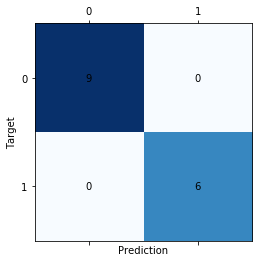

In [32]:
"""
Below, plot and display the confusion matrix of your prediction with respect to 
true values. Use provided functions for plotting.
"""

#solution
plot_confusion_matrix(testExamples_classes, preds)
#end_solution


&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_ The results using a single sigmoid function in a binary classifier where the classifications have a value of 0 or 1 do not work efficiently when applying the sigmoid as the values close to 1 and 0 are ambiguated even further by being pushed close to 0.5.
We can also create two classifiers for being Setosa and not being Setosa. The results of these classifiers are compared and the classification with a higer value is designated as the predicted class.
This however is here tackeled by changing the activation function to setting a simple threshold for the classification to 0.5 as the classification is already producing float results close to 0 and 1.

**3c**
<a name='question3c'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [33]:
def softmax(preds):
  """
  Write your implementation of the softmax activation here.

  Arguments:
  preds : The output predicted classes from your classifier

  Returns:
  activation : The outputs after applying softmax activation
  """

  #solution
  activation = []
  for i in range(len(preds)):
      activation.append(np.exp(preds[i]) / (np.sum(np.exp(preds),axis=0)))
  #print(len(preds))
  activation = np.array(activation)
  #end_solution


  return activation

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [34]:
def lclass_prob(examplesA, examplesB, testExample):
    """
    Write your implementation of lclass_prob here.

    Arguments:
    examplesA : Matrix of samples from class A
    examplesB : Matrix of samples from class B
    testExample : Matrix of test samples to predict on

    Returns:
    preds : Predicted probabilities of samples in testExample belonging to a class.
    """
    
    #solution
    
    # XY_a = np.column_stack([examplesA,np.ones([len(examplesA), 1]),np.zeros([len(examplesA), 1])]) #Adding columns for class==0, class==1
    # XY_b = np.column_stack([examplesB,np.zeros([len(examplesB), 1]),np.ones([len(examplesB), 1])]) #Adding columns for class==0, class==1

    XY_a = np.column_stack([examplesA,np.ones([len(examplesA), 1])]) #Adding columns for class==1
    XY_b = np.column_stack([examplesB,np.zeros([len(examplesB), 1])]) #Adding columns for class==1
    XY = np.append(XY_a,XY_b, axis=0) #Combining training data for both classes


    #Preparing training data
    X = np.delete(XY, [4], 1) 
    X = np.column_stack([np.ones([len(X), 1]), X])
    y = np.delete(XY, [0,1,2,3], 1)
    w = nsolve(X, y)
    #print(w)




    # Predictions for likelihood class == 0 , likelihood class == 1
    #preds = np.column_stack([testExample.dot(w[:,0]), testExample.dot(w[:,1])])



    testExample = np.column_stack([np.ones([len(testExample), 1]), testExample])
    # Predictions for likelihood class == 0 , likelihood class == 1
    preds_all = testExample.dot(w)
    #print(preds_all)

    preds = []
    for i in range(len(preds_all)):
        preds.append(preds_all[i][0])

    #end_solution

    
    return preds

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [35]:
def lmclass(examples, labels, testExample):
    """
    Write your implementation of multiclass classifier lmclass here.
    Use your lclass_prob implementation here to solve this.

    Arguments:
    examples : The training data matrix
    labels : The training labels
    testExample : The testing data matrix

    Returns:
    preds_prob : For each sample in testExample, their predicted probabilities
                 of belonging to each class
    """

    #solution

    yx_train = np.column_stack([labels, examples])

    classes = []
    for label in labels:
        if label not in classes:
            classes.append(label)

    Train = {}
    for i in range(len(classes)):
        Train[classes[i]] = []


    for i in range(len(classes)):
        for j in range(len(yx_train)):
            if (yx_train[j][0] == classes[i]):
                Train[classes[i]].append(examples[j])
    

    lclass_probs = {}
    for i in classes:
        lclass_probs[i] = []
    

    for i in range(len(classes)):
        class_0 = []
        class_1 = []
        for element in Train[classes[i]]:
            class_0.append(element)
        for j in range(len(classes)):
            if i != j:
                for element in Train[classes[j]]:
                    class_1.append(element)

        lclass_probs[classes[i]] = np.array((lclass_prob(np.array(class_0), np.array(class_1), testExample)))

    preds_prob = lclass_probs


    #end_solution

    
    return preds_prob

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [36]:
#solution
x_train = X_iris
y_train = Y_iris
y_test = Y_iris_test
x_test = X_iris_test

yx_train = np.column_stack([y_train, x_train])
yx_test = np.column_stack([y_test, x_test])

Iris_Setosa_Train = [] # Label 0
Iris_Versicolour_Train = [] # Label 1
Iris_Virginica_Train = [] # Label 2
Iris_Setosa_Test = [] # Label 0
Iris_Versicolour_Test = [] # Label 1
Iris_Virginica_Test = [] # Label 2

for i in range(len(yx_train)):
    if (yx_train[i][0] == 0):
        Iris_Setosa_Train.append(x_train[i])
    elif (yx_train[i][0] == 1):
        Iris_Versicolour_Train.append(x_train[i])
    elif (yx_train[i][0] == 2):
        Iris_Virginica_Train.append(x_train[i])

for i in range(len(yx_test)):
    if (yx_test[i][0] == 0):
        Iris_Setosa_Test.append(x_test[i])
    elif (yx_test[i][0] == 1):
        Iris_Versicolour_Test.append(x_test[i])
    elif (yx_test[i][0] == 2):
        Iris_Virginica_Test.append(x_test[i])

Iris_Setosa_Train_labelled = np.column_stack([Iris_Setosa_Train,np.full((len(Iris_Setosa_Train),1), "Iris_Setosa")])
Iris_Versicolour_Train_labelled  = np.column_stack([Iris_Versicolour_Train,np.full((len(Iris_Versicolour_Train),1), "Iris_Versicolour")])
Iris_Virginica_Train_labelled  = np.column_stack([Iris_Virginica_Train,np.full((len(Iris_Virginica_Train),1), "Iris_Virginica")])

examples = np.append(Iris_Setosa_Train_labelled,Iris_Versicolour_Train_labelled, axis=0)
examples = np.append(examples,Iris_Virginica_Train_labelled, axis=0)

examples = np.take(examples,np.random.permutation(examples.shape[0]),axis=0,out=examples);
examples_values = np.delete(examples, 4, 1).astype(np.float64)
examples_classes = np.array(([row[4] for row in examples]))


Iris_Setosa_Test_labelled = np.column_stack([Iris_Setosa_Test,np.full((len(Iris_Setosa_Test),1), "Iris_Setosa")])
Iris_Versicolour_Test_labelled = np.column_stack([Iris_Versicolour_Test,np.full((len(Iris_Versicolour_Test),1), "Iris_Versicolour")])
Iris_Virginica_Test_labelled = np.column_stack([Iris_Virginica_Test,np.full((len(Iris_Virginica_Test),1), "Iris_Virginica")])

testExamples = np.append(Iris_Setosa_Test_labelled,Iris_Versicolour_Test_labelled, axis=0)
testExamples = np.append(testExamples,Iris_Virginica_Test_labelled, axis=0)

testExamples = np.take(testExamples,np.random.permutation(testExamples.shape[0]),axis=0,out=testExamples);
testExamples_values = np.delete(testExamples, 4, 1).astype(np.float64)
testExamples_classes = np.array(([row[4] for row in testExamples]))

preds = lmclass(examples_values, examples_classes, testExamples_values)

preds_prob = []
classes = ["Iris_Setosa","Iris_Versicolour","Iris_Virginica"]
for i in range(len(classes)):
    preds_prob.append(preds[classes[i]])


pred_args = np.argmax(softmax(preds_prob),axis=0)
preds = []
for i in range(len(pred_args)):
    preds.append(classes[pred_args[i]])

print("Test Labels vs Predictions:")
print(np.column_stack([testExamples_classes, preds]))
#end_solution


Test Labels vs Predictions:
[['Iris_Versicolour' 'Iris_Versicolour']
 ['Iris_Virginica' 'Iris_Virginica']
 ['Iris_Setosa' 'Iris_Setosa']
 ['Iris_Setosa' 'Iris_Setosa']
 ['Iris_Setosa' 'Iris_Setosa']
 ['Iris_Versicolour' 'Iris_Versicolour']
 ['Iris_Versicolour' 'Iris_Virginica']
 ['Iris_Virginica' 'Iris_Virginica']
 ['Iris_Setosa' 'Iris_Setosa']
 ['Iris_Virginica' 'Iris_Virginica']
 ['Iris_Versicolour' 'Iris_Versicolour']
 ['Iris_Setosa' 'Iris_Setosa']
 ['Iris_Versicolour' 'Iris_Virginica']
 ['Iris_Setosa' 'Iris_Setosa']
 ['Iris_Versicolour' 'Iris_Versicolour']]


**3d**
<a name='question3d'></a>

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_

## 4. Non-linear Classification (25 points)
<a name='question4'></a>

[a)](#question4a) Implement classification based on logistic regression using GD by implementing the gradient function dlogistic(preds, X, Y) and optimizing using GD. preds are the prediction from the model, X are the data and Y are the labels. Propose a function interface for your implementation of the gradient descent algorithm. (**4 points** + **1 points** on hidden dataset)

[b)](#question4b) Implement classification based on hinge loss using GD by implementing the gradient function dhinge(preds,
W, X, Y) and optimizing using GD. preds are the prediction from the model, W describes the model parameters, X is the data and Y represent the labels. Propose a function interface for your implementation
of the gradient descent algorithm. (**8 points** + **2 points** on hidden dataset)

[c)](#question4c) Implement kernel SVM function ksvm(kernel, X, Y, X_test). The function takes as input a kernel function kernel, training data X, Y and a set of test points X_test. The function returns the set of support vectors along with the predicted labels. You are allowed to use scipy optimization library to solve the quadratic problem of SVM. (**8 points** + **2 points** on hidden dataset)

**4.a**
<a name='question4a'></a>

Implementation of the sigmoid activation function and Logistic Regression.

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [37]:
def sigmoid(z):
    """
    Implement sigmoid activation function here.

    Arguments:
    z : Input scalar or batch of scalars

    Returns:
    activation : Sigmoid activation(s) on z
    """
    
    #solution
    activation = 1 / (1 + np.exp(-z))
    #end_solution


    return activation

def predict(X, W):
    """
    Implement your prediction function here.

    Arguments:
    X : Data matrix
    W : Weight matrix

    Returns:
    prediction : Predicted values using the weights
    """

    #solution

    X = np.column_stack([np.ones([len(X), 1]), X])
    prediction = sigmoid(X.dot(W))

    #prediction = sig_array


    #end_solution

    
    return prediction

Implementation of the loss function

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [38]:
def logistic_loss(preds, targets):
    """
    Implement your logistic loss function here.

    Arguments:
    preds : Predicted values
    targets : Target values

    Returns :
    cost : The mean logistic loss value between preds and targets
    """

    #solution
    #print(targets)
    #print(preds)
    #m = len(targets)
    cost = -np.sum(targets*np.log(preds) + (1-targets)*np.log(1-preds))
    #print(cost)

    #end_solution


    return cost

Implementation of the gradient

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [39]:
def dlogistic(preds, X, Y):
    """
    Implement the derivative of the logistic loss here.

    Arguments:
    preds : Predicted values
    X : Input data matrix
    Y : True target values
    """

    #solution

    X = np.column_stack([np.ones([len(X), 1]), X])

    J = -np.sum((Y-preds).dot(X))

    #end_solution

    
    return J

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [40]:
def gd(X, Y, gradient, step_size, max_it):
    """
    Implement Gradient Descent here with Logistic loss and its gradient.
    Print the loss values at some interval
    of your choice.

    Arguments:
    X : Data matrix
    Y : Labels
    gradient : A callable function that can be used as gradient(preds,X,Y) 
              and returns gradient of the loss.
    step_size : Float value of step size to take.
    max_it : Maximum number of iterations, after which to stop

    Returns:
    history : A list containing the loss value at each iteration
    best_w : The best weights corresponding to the best loss value
    """
    
    #solution
    n,d = X.shape
    W = np.random.rand(d+1, 1)
    #print(W)
    prediction = predict(X, W)
    

    cost = logistic_loss(prediction, Y)
    #print(cost)
    #lowest_loss = cost
    best_w = W
    history = [cost]


    for i in range(max_it):
        prediction = predict(X, W)
        cost = logistic_loss(prediction, Y)
        history.append(cost)
        if 0 == (i %1000):
            print(cost)
        if cost < 16000:
            #lowest_loss = cost
            best_w = W
            return history, best_w
        J = gradient(prediction, X, Y)
        W = W - (step_size*J)




    #end_solution

    
    return history, best_w

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [41]:
"""
After implementing logistic_loss, dlogistic and gd, test it below using the IRIS dataset.
"""

#solution

x_train = X_iris
y_train = Y_iris
y_test = Y_iris_test
x_test = X_iris_test

yx_train = np.column_stack([y_train, x_train])
yx_test = np.column_stack([y_test, x_test])

Iris_Setosa_Train = [] # Label 0
Iris_Not_Setosa_Train = [] # Label 1 or 2
Iris_Setosa_Test = [] # Label 0
Iris_Not_Setosa_Test = [] # Label 1 or 2

for i in range(len(yx_train)):
    if (yx_train[i][0] == 0):
        Iris_Setosa_Train.append(yx_train[i][1:])
    elif ((yx_train[i][0] == 1) or (yx_train[i][0] == 2)):
        Iris_Not_Setosa_Train.append(yx_train[i][1:])

for i in range(len(yx_test)):
    if (yx_test[i][0] == 0):
        Iris_Setosa_Test.append(yx_test[i][1:])
    elif ((yx_test[i][0] == 1) or (yx_test[i][0] == 2)):
        Iris_Not_Setosa_Test.append(yx_test[i][1:])

Iris_Setosa_Train_0 = np.column_stack([Iris_Setosa_Train,np.zeros([len(Iris_Setosa_Train), 1])])
Iris_Not_Setosa_Train_1 = np.column_stack([Iris_Not_Setosa_Train,np.ones([len(Iris_Not_Setosa_Train), 1])])
trainExamples = np.append(Iris_Setosa_Train_0,Iris_Not_Setosa_Train_1, axis=0)

trainExamples = np.take(trainExamples,np.random.permutation(trainExamples.shape[0]),axis=0,out=trainExamples);
trainExamples_values = np.delete(trainExamples, 4, 1)
trainExamples_classes = np.array(([int(row[4]) for row in trainExamples]))


Iris_Setosa_Test_0 = np.column_stack([Iris_Setosa_Test,np.zeros([len(Iris_Setosa_Test), 1])])
Iris_Not_Setosa_Test_1 = np.column_stack([Iris_Not_Setosa_Test,np.ones([len(Iris_Not_Setosa_Test), 1])])
testExamples = np.append(Iris_Setosa_Test_0,Iris_Not_Setosa_Test_1, axis=0)

testExamples = np.take(testExamples,np.random.permutation(testExamples.shape[0]),axis=0,out=testExamples);
testExamples_values = np.delete(testExamples, 4, 1)
testExamples_classes = np.array(([int(row[4]) for row in testExamples]))

history, best_w = gd(trainExamples_values, trainExamples_classes, dlogistic, 0.0000000005, 2000000)
preds = predict(testExamples_values, best_w)
predictions = []
for pred in preds:
    if pred>0.75:
        predictions.append(1)
    else:
        predictions.append(0)
predictions = np.array(predictions)

print("Predictions: ",preds)
print("Groundtruth: ",testExamples_classes)


#end_solution


44837.60228645941
41949.375825229676
39075.57239227711
36223.07399686121
33402.04631837167
30627.388008971837
27920.60468596256
25311.921333043047
22841.970273178304
20561.578762728917
18527.359193604552
16791.205705805383
Predictions:  [[0.92732743]
 [0.85989838]
 [0.92058646]
 [0.89487174]
 [0.88856253]
 [0.90654189]
 [0.90857032]
 [0.94836208]
 [0.85113032]
 [0.85973682]
 [0.94259419]
 [0.92881093]
 [0.89314818]
 [0.86384473]
 [0.93375436]]
Groundtruth:  [1 0 1 1 0 1 1 1 0 0 1 1 0 0 1]


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

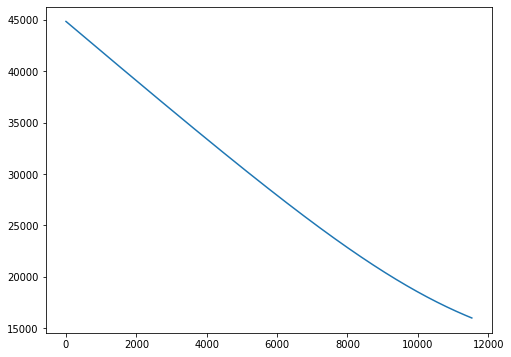

In [42]:
"""
Plot and display the progression of your loss values as a graph. Use the 
provided plotting functions.
"""

#solution
plot_loss_curve(history)

#end_solution


**4.b**
<a name='question4b'></a>

Implementation of the Hinge Loss and its gradient:

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [43]:
def hinge_loss(z, Y):
    """
    Write your implementation of hinge loss here.

    Arguments:
    z : Classifier score
    Y : Label

    Returns:
    avg : The average hinge loss
    """

    #solution
    sum = 0
    for i in range(len(Y)):
        #print(z[i][0])
        #print(Y[i])
        sum+=max(0, 1-float(z[i]*Y[i]))
    avg = sum/len(Y)

    #end_solution


    return avg
  
def dhinge(preds, W, X, Y):
    """
    Implement the derivative of hinge_loss here.

    Arguments:
    preds : The predicted values.
    W : Weights
    X : Data matrix
    Y : True Labels

    Returns:
    J : Gradient of avg hinge_loss with respect to predicted values.
    """

    #solution
    # −yx if yx⋅w<1
    # 0 if yx⋅w>1
    #n,d = W.shape
    J = np.array([0,0,0,0,0])
    X = np.column_stack([np.ones([len(X), 1]), X])


    for i in range(len(Y)):
        #print(preds[i][0])
        if preds[i]>1:
            J=J
        else:
            #print(Y[i])
            #print(X[i])
            #print(J)
            J=J-X[i].dot(Y[i])






    #end_solution

    
    return J

Implementation of the full gradient descent:

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [44]:
def gd(X, Y, gradient, step_size, max_it):
    """
    Implement Gradient Descent here with hinge_loss and its gradient.
    Print the loss values at some interval
    of your choice.

    Arguments:
    X : Data matrix
    Y : Labels
    gradient : A callable function that can be used as gradient(z,W,X,Y) 
               and returns gradient of the loss.
    step_size : Float value of step size to take.
    max_it : Maximum number of iterations, after which to stop

    Returns:
    history : A list containing the loss value at each iteration
    best_w : The best weights corresponding to the best loss value
    """
    
    #solution

    n,d = X.shape
    W = np.array([0,0,0,0,0])
    #print(W)
    prediction = predict(X, W)
    

    #cost = logistic_loss(prediction, Y)
    cost = hinge_loss(prediction, Y)
    #print(cost)
    lowest_loss = cost
    best_w = W
    history = [cost]


    for i in range(max_it):
        prediction = predict(X, W)
        cost = hinge_loss(prediction, Y)
        history.append(cost)
        if 0 == (i %1000):
            print(cost)
        if cost < lowest_loss:
            lowest_loss = cost
            best_w = W
        J = gradient(prediction, W, X, Y)
        W = W - (step_size*J)
        #print(W)



    #end_solution

    
    return history, best_w

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [45]:
"""
After implementing hinge_loss, dhinge and gd, test it below on the IRIS dataset.
"""

#solution

x_train = X_iris
y_train = Y_iris
y_test = Y_iris_test
x_test = X_iris_test

yx_train = np.column_stack([y_train, x_train])
yx_test = np.column_stack([y_test, x_test])

Iris_Setosa_Train = [] # Label 0
Iris_Not_Setosa_Train = [] # Label 1 or 2
Iris_Setosa_Test = [] # Label 0
Iris_Not_Setosa_Test = [] # Label 1 or 2

for i in range(len(yx_train)):
    if (yx_train[i][0] == 0):
        Iris_Setosa_Train.append(yx_train[i][1:])
    elif ((yx_train[i][0] == 1) or (yx_train[i][0] == 2)):
        Iris_Not_Setosa_Train.append(yx_train[i][1:])

for i in range(len(yx_test)):
    if (yx_test[i][0] == 0):
        Iris_Setosa_Test.append(yx_test[i][1:])
    elif ((yx_test[i][0] == 1) or (yx_test[i][0] == 2)):
        Iris_Not_Setosa_Test.append(yx_test[i][1:])

Iris_Setosa_Train_0 = np.column_stack([Iris_Setosa_Train,np.zeros([len(Iris_Setosa_Train), 1])])
Iris_Not_Setosa_Train_1 = np.column_stack([Iris_Not_Setosa_Train,np.ones([len(Iris_Not_Setosa_Train), 1])])
trainExamples = np.append(Iris_Setosa_Train_0,Iris_Not_Setosa_Train_1, axis=0)

trainExamples = np.take(trainExamples,np.random.permutation(trainExamples.shape[0]),axis=0,out=trainExamples);
trainExamples_values = np.delete(trainExamples, 4, 1)
trainExamples_classes = np.array(([int(row[4]) for row in trainExamples]))


Iris_Setosa_Test_0 = np.column_stack([Iris_Setosa_Test,np.zeros([len(Iris_Setosa_Test), 1])])
Iris_Not_Setosa_Test_1 = np.column_stack([Iris_Not_Setosa_Test,np.ones([len(Iris_Not_Setosa_Test), 1])])
testExamples = np.append(Iris_Setosa_Test_0,Iris_Not_Setosa_Test_1, axis=0)

testExamples = np.take(testExamples,np.random.permutation(testExamples.shape[0]),axis=0,out=testExamples);
testExamples_values = np.delete(testExamples, 4, 1)
testExamples_classes = np.array(([int(row[4]) for row in testExamples]))

history, best_w = gd(trainExamples_values, trainExamples_classes, dhinge, 0.00000001, 40000)
preds = predict(testExamples_values, best_w)
predictions = []
for pred in preds:
    if pred>0.9:
        predictions.append(1)
    else:
        predictions.append(0)
predictions = np.array(predictions)

print("Predictions: ",predictions)
print("Groundtruth: ",testExamples_classes)

#end_solution


0.662962962962963
0.6514146107765825
0.6398944893701308
0.6284305393372824
0.6170501275292861
0.6057797764885084
0.5946449127077932
0.5836696388085003
0.5728765338129167
0.5622864846504168
0.5519185509397003
0.5417898639896604
0.5319155599119303
0.5223087457838935
0.5129804969761775
0.503939883086803
0.4951940194163357
0.48674814057583515
0.4786056926342945
0.470768440169429
0.463236584665736
0.4560088908841418
0.4490828180849803
0.44245465329787975
0.43611964417737964
0.43007212934342803
0.424305664465851
0.41881314269921244
0.41358690839985235
0.40861886335395725
0.4039005650102287
0.39942331644124285
0.3951782479536883
0.391156390430443
0.38734874061890584
0.38374631868279635
0.3803402184117794
0.3771216505379634
0.3740819796437145
0.37121275516439906
Predictions:  [1 1 1 0 1 0 1 0 1 1 1 0 1 0 0]
Groundtruth:  [1 1 1 0 1 0 1 0 1 1 1 0 1 0 0]


&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

0.36850836567737927


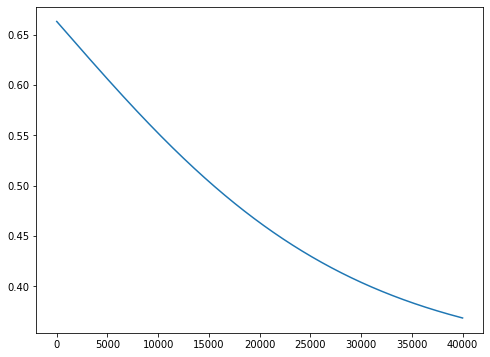

In [46]:
"""
Print the minimum loss
Plot and display the progression of loss. Use provided plotting functions
"""

#solution

print(np.min(history))
plot_loss_curve(history)

#end_solution


**4.c**
<a name='question4c'></a>

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [47]:
def ksvm(kernel, X, Y, X_test):
    """
    Write your implementation of Kernel SVM here.

    Arguments:
    kernel : A callable function that takes 2 samples and returns the score
             for them.
    X : Training data matrix
    Y : Training Labels as -1/1
    X_test : Test data matrix

    Returns:
    support_vectors : The learned support vectors
    preds : The predicted labels as -1/1 on the given Test data
    """
    
    #solution


    score = kernel(x1, x2)




    #preds = predict(X_test, best_w)

    #end_solution


    return support_vectors, preds

In [48]:
X_iris_svm = np.copy(X_iris)
Y_iris_svm = np.copy(Y_iris)
Y_iris_svm[Y_iris==0] = -1
Y_iris_svm[Y_iris!=0] = 1

Y_iris_test_svm = np.copy(Y_iris_test)
Y_iris_test_svm[Y_iris_test==0] = -1
Y_iris_test_svm[Y_iris_test!=0] = 1

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [49]:
def kernel(x1, x2):
    """
    Define your kernel function here.

    Arguments:
    x1, x2 : Two data samples (vectors)

    Returns:
    score : The score between x1 and x2
    """

    #solution

    score = np.power((1+x1.T.dot(x2)),2)

    #end_solution


    return score

"""
After implementing ksvm and kernel, test it below on the IRIS dataset.
Print the accuracy of the model.
"""

#solution

x_train = X_iris
y_train = Y_iris
y_test = Y_iris_test
x_test = X_iris_test

yx_train = np.column_stack([y_train, x_train])
yx_test = np.column_stack([y_test, x_test])

Iris_Setosa_Train = [] # Label 0
Iris_Not_Setosa_Train = [] # Label 1 or 2
Iris_Setosa_Test = [] # Label 0
Iris_Not_Setosa_Test = [] # Label 1 or 2

for i in range(len(yx_train)):
    if (yx_train[i][0] == 0):
        Iris_Setosa_Train.append(yx_train[i][1:])
    elif ((yx_train[i][0] == 1) or (yx_train[i][0] == 2)):
        Iris_Not_Setosa_Train.append(yx_train[i][1:])

for i in range(len(yx_test)):
    if (yx_test[i][0] == 0):
        Iris_Setosa_Test.append(yx_test[i][1:])
    elif ((yx_test[i][0] == 1) or (yx_test[i][0] == 2)):
        Iris_Not_Setosa_Test.append(yx_test[i][1:])

Iris_Setosa_Train_0 = np.column_stack([Iris_Setosa_Train,np.zeros([len(Iris_Setosa_Train), 1])])
Iris_Not_Setosa_Train_1 = np.column_stack([Iris_Not_Setosa_Train,np.ones([len(Iris_Not_Setosa_Train), 1])])
trainExamples = np.append(Iris_Setosa_Train_0,Iris_Not_Setosa_Train_1, axis=0)

trainExamples = np.take(trainExamples,np.random.permutation(trainExamples.shape[0]),axis=0,out=trainExamples);
trainExamples_values = np.delete(trainExamples, 4, 1)
trainExamples_classes = np.array(([int(row[4]) for row in trainExamples]))


Iris_Setosa_Test_0 = np.column_stack([Iris_Setosa_Test,np.zeros([len(Iris_Setosa_Test), 1])])
Iris_Not_Setosa_Test_1 = np.column_stack([Iris_Not_Setosa_Test,np.ones([len(Iris_Not_Setosa_Test), 1])])
testExamples = np.append(Iris_Setosa_Test_0,Iris_Not_Setosa_Test_1, axis=0)

testExamples = np.take(testExamples,np.random.permutation(testExamples.shape[0]),axis=0,out=testExamples);
testExamples_values = np.delete(testExamples, 4, 1)
testExamples_classes = np.array(([int(row[4]) for row in testExamples]))


support_vectors, preds = ksvm(kernel, trainExamples_values, trainExamples_classes, testExamples_values)

predictions = []
for pred in preds:
    if pred>0.9:
        predictions.append(1)
    else:
        predictions.append(0)
predictions = np.array(predictions)

print("Predictions: ",predictions)
print("Groundtruth: ",testExamples_classes)

print("Learned Support Vectors: ",support_vectors)



#end_solution


NameError: name 'x1' is not defined

## 5. Neural Networks (25 points)
<a name='question5'></a>

[a)](#question5a) Devise a three-layer neural network with n hidden states and sigmoid activations for classification. Explain how many parameters this has in one sentence. (**2 points**)

[b)](#question5b) For each weight and bias in the network in point a), derive and write the equation for the gradient using chain rule. You can use Latex in markdown to write the math. (**8 points**)

[c)](#question5c) Implement the binary classifier nnclass(examplesA, examples, testExamples) that is trained with your implementation of (stochastic) GD and your gradient function using the network. (**8 points** + **2 points** on hidden dataset)

[d)](#question5d) Do an analysis how changes affect the accuracy with _MNIST_. Positive labels are assigned to digit 1 and negative samples to other digits. Write no longer than fifteen sentences. A table and / or plot is welcome. (**5 points**)

**5.a**
<a name='question5a'></a>

Implementation of the activation function and its associated gradient:

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [50]:
def sigmoid(z):
    """
    Write your activation function here.

    Arguments:
    z : Scalar or batch of scalars on which to compute activation(s)

    Returns:
    activation : The activation value(s)
    """

    #solution
    activation = 1 / (1 + np.exp(-z))
    #end_solution


    return activation

def dsigmoid(z):
    """
    Implement the gradient of the activation function.

    Arguments:
    z : Scalar or batch of scalars

    Returns:
    gradient : Gradient(s) of the activation function
    """

    #solution
    gradient = sigmoid(z)*(1-sigmoid(z))
    #end_solution


    return gradient

Implementation of the forward pass:

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [51]:
def forward_pass(x, W, b):
    """
    Write your implementation of forward pass here.

    Arguments:
    x : Input data matrix
    W : Tuple of weight matrices
    b : Tuple of biases

    Returns:
    y_hat : Output of last layer
    cache : A tuple, that contains all intermediate outputs. These will be
            needed in your backward pass. Save anything in cache that you
            plan to use in the backward pass. It should be a tuple
    """

    #solution

    cache = []
    #print(W[0].shape)
    #print(W[1].shape)
    #print(W[2].shape)
    Z1 = np.matmul(W[0], X) + b[0]
    #print("Z1 shape: ", Z1.shape)
    cache.append(Z1)
    A1 = sigmoid(Z1)
    #print("A1 shape: ", A1.shape)
    cache.append(A1)
    Z2 = np.matmul(W[1], A1) + b[1]
    #print("Z2 shape: ", Z2.shape)
    cache.append(Z2)
    A2 = sigmoid(Z2)
    #print("A2 shape: ", A2.shape)
    cache.append(A2)
    Z3 = np.matmul(W[2], A2) + b[2]
    #print("Z3 shape: ", Z3.shape)
    cache.append(Z3)
    A3 = sigmoid(Z3)
    #print("A3 shape: ", A3.shape)
    cache = tuple(cache)
    y_hat = A3
    

    #end_solution


    return y_hat, cache

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_

**5.b**
<a name='question5b'></a>

_Forward pass:_

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_

_Backward pass - weights:_

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_

_Backward pass - parameters:_

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_

**5.c**
<a name='question5c'></a>

Implementation of the loss and its associated gradient:

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [52]:
def loss(preds, targets):
    """
    Write your loss function here.

    Arguments:
    preds: The network predictions
    targets: The true labels

    Returns:
    cost: An error metric between pred and targets
    """

    #solution
    # Using sum of squares method
    #cost = np.sum((preds-targets)**2)
    
    # Using cross entropy loss function
    N = targets.shape[0]
    #print(preds)
    #print(targets)
    cost=-(1./N)*(np.sum(np.multiply(np.log(preds),targets))+np.sum(np.multiply(np.log(1-preds),(1-targets))))
    #end_solution

    
    return cost

def dloss(preds, target):
    """
    Write the derivative of loss function here.

    Arguments:
    preds : The network predictions
    target : The true labels

    Returns:
    gradient : The derivative of loss function with respect to the
              network outputs
    """

    #solution

    #gradient for the cross entropy loss
    gradient = (preds-target)/(preds*(1.0-preds))

    #end_solution


    return gradient

Implementation of the backward pass:

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [68]:
def backward_pass(preds, targets, W, b, X, cache):
    """
    Write your implementation of backward_pass here.

    Arguments:
    preds : The network predictions
    targets : The true labels
    W : A tuple of weight matrices
    b : A tuple of bias values
    X : Input data matrix
    cache : Tuple of Intermediate outputs that you cached in forward_pass

    Returns:
    Gradients with respect to each layer's weights and biases
    """
    
    #solution
    # Change this to the correct function later
    # Also what to use X and b for?
    Z1 = cache[0]
    A1 = cache[1]
    Z2 = cache[2]
    A2 = cache[3]
    Z3 = cache[4]

    N = targets.shape[0]
    
    print(dloss(preds,targets).shape)
    print(dsigmoid(Z3).shape)

    dZ3 = dloss(preds,targets).dot(dsigmoid(Z3))
    J_w3 = (1.0/N) * np.matmul(dZ3, A2.T)
    J_b3 = (1.0/N) * np.sum(dZ3, axis=1, keepdims=True)
    dA2 = np.matmul(W[2].T, dZ3)

    dZ2 = dA2 * dsigmoid(Z2)
    J_w2 = (1.0/N) * np.matmul(dZ2, A1.T)
    J_b2 = (1.0/N) * np.sum(dZ2, axis=1, keepdims=True)
    dA1 = np.matmul(W[1].T, dZ2)

    dZ1 = dA1 * dsigmoid(Z1)
    J_w1 = (1.0/N) * np.matmul(dZ1, X.T)
    J_b1 = (1.0/N) * np.sum(dZ1, axis=1, keepdims=True)


    #end_solution

    
    return J_w3, J_w2, J_w1, J_b3, J_b2, J_b1

&#9998; <font color="#0047AB">
You need to modify the following cell with your own code.
</font>

In [69]:
def training(X, Y, W, b, step_size, max_it):
    """
    Implement your training loop here.

    Arguments:
    X : Input Data matrix
    Y : True labels
    W : A tuple of weight matrices
    step_size : The step size to take for network updates
    max_it : The maximum iterations after which to stop

    Returns:
    W : The trained weights
    b : The trained biases
    history : A list of your loss values at each iteration
    """
    
    #solution
    #print(W[0].shape)
    history = []
    for i in range(max_it):
        y_hat, cache = forward_pass(X, W, b)
        cost = loss(y_hat, Y)
        history.append(cost)
        if (max_it % 5) == 0:
            print(cost)
        J_w3, J_w2, J_w1, J_b3, J_b2, J_b1 = backward_pass(y_hat, Y, W, b, X, cache)

        W3 = W[2] - step_size * J_w3
        b3 = b[2] - step_size * J_b3
        W2 = W[1] - step_size * J_w2
        b2 = b[1] - step_size * J_b2
        W1 = W[0] - step_size * J_w1
        b1 = b[0] - step_size * J_b1
        W = tuple([W1,W2,W3])
        b = tuple([b1,b2,b3])
    #end_solution

            
    return W, b, history

In [70]:
"""
Below, initialize the weights and biases randomly.
Start your training loop with your choice of parameters step_size, max_it
"""

#solution

#X_mnist, X_mnist_test, Y_mnist, Y_mnist_test
classes = 1 #Classification for single class
X = X_mnist.T
#print("X shape: ", X.shape)
Y = Y_mnist
#print("Y shape: ", Y.shape)
X_test = X_mnist_test
Y_test = Y_mnist_test

d = X.shape[0]
n_h1 = 64 #Try 48/64
n_h2 = 24 #Try 8/10
step_size = 0.002

W1 = np.random.randn(n_h1, d)
#print("W1 shape: ", W1.shape)
b1 = np.zeros((n_h1, 1))
#print("b1 shape: ", b1.shape)
W2 = np.random.randn(n_h2, n_h1)
#print("W2 shape: ", W2.shape)
b2 = np.zeros((n_h2, 1))
#print("b2 shape: ", b2.shape)
W3 = np.random.randn(classes, n_h2)
#print("W3 shape: ", W3.shape)
b3 = np.zeros((classes, 1))
#print("b3 shape: ", b3.shape)
W = tuple([W1,W2,W3])
b = tuple([b1,b2,b3])


W, b, history = training(X, Y, W, b, step_size, 35)

Z1 = np.matmul(W[0], X_test.T) + b[0]
A1 = sigmoid(Z1)
Z2 = np.matmul(W[1], A1) + b[1]
A2 = sigmoid(Z2)
Z3 = np.matmul(W[2], A2) + b[2]
A3 = sigmoid(Z3)
y_hat = A3 


#end_solution



8.323264199414046
(1, 63000)
(1, 63000)


ValueError: shapes (1,63000) and (1,63000) not aligned: 63000 (dim 1) != 1 (dim 0)

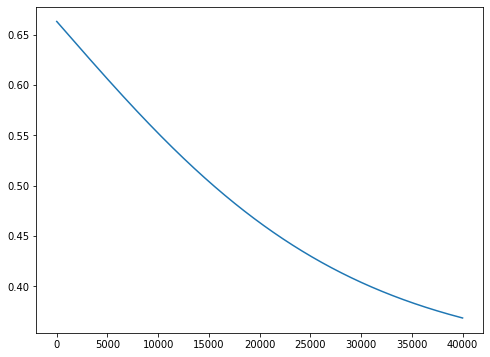

In [71]:
"""
Plot and display the progression of your loss across iterations. Use provided plotting functions.
"""

#solution

plot_loss_curve(history)

#end_solution



**5.d**
<a name='question5d'></a>

&#9998; <font color="#0047AB">
Double click on the cell below to edit and add your reply in text.
</font>

_Your reply:_